# Import packages

In [1]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import glob
from PIL import Image

# Load dataset

In [2]:
train = pd.read_csv('./fashion-mnist_train.csv')

# 이미지 파일 경로 목록 불러오기
image_files = sorted(glob.glob('./data/*.png'))

# 이미지 파일 불러오기
images = []
for image_file in image_files:
    image = Image.open(image_file)
    image = image.convert('L')  # 'L': 8-bit pixels, black and white
    image = np.array(image)
    images.append(image)

# 이미지 배열로 변환
test = np.array(images)
# 이미지 배열을 2차원으로 변환
test_flattened = test.reshape(test.shape[0], -1)

In [3]:
df_train = train.copy()
df_test = pd.DataFrame(test_flattened, columns=[f"pixel{i+1}" for i in range(test_flattened.shape[1])])

In [4]:
df_test

pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0           0       0       0       0       0       0       0       0       0   
1           0       0       0       0       0       0       0       1       1   
2           0       0       0       0       0       0       0       0       0   
3           0       0       0       0       0       0       0       0       0   
4           0       0       0       0       0       0       0       0       0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
14995       0       0       0       0       0       0       0       0       0   
14996       0       0       0       0       0       0       0       0       0   
14997       0       0       0       0       0       0       0       0       0   
14998       0       0       0       0       0       0       0       0       0   
14999       0       0       0       0       0       0       0       0       0   

       pixel10  ...  pixel775  pixel776  pixel777  pixel778  pixel779  \
0            0  ...         0         0         0        97        93   
1            0  ...       141        94         0         0       105   
2            0  ...       125         0         0         0         0   
3            1  ...         0         0         0         0         0   
4            0  ...         0         0         0         0         0   
...        ...  ...       ...       ...       ...       ...       ...   
14995        0  ...        84        92        43         0         0   
14996        0  ...         0         0         0         0         0   
14997        0  ...       172       148       139        92        10   
14998       12  ...       129       133       125         0         0   
14999        0  ...        80         0         0         0         0   

       pixel780  pixel781  pixel782  pixel783  pixel784  
0            58         0         0         0         0  
1             7         0         0         0         0  
2             0         0         0         0         0  
3             0         0         0         0         0  
4             0         0         0         0         0  
...         ...       ...       ...       ...       ...  
14995         0         0         0         0         0  
14996         0         0         0         0         0  
14997         2         2         0         0         0  
14998         0         0         0         0         0  
14999         0         0         0         0         0  

[15000 rows x 784 columns]

# Examine NaN values

In [19]:
df_train.isnull().any().sum()

0

In [7]:
df_test.isnull().any().sum()

0

# Separating data and label

In [8]:
X_train= df_train.drop(['label'],axis = 1)
y_train = df_train['label']
X_test = df_test

# Check data

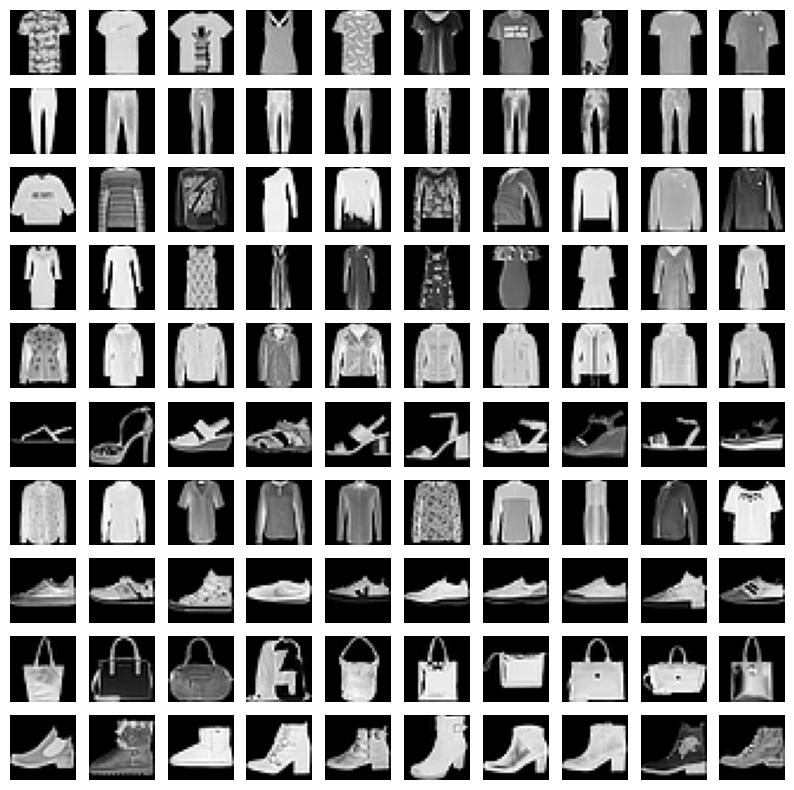

In [9]:
# Reshape the features to 28x28 images
X_train_reshaped = X_train.values.reshape(-1, 28, 28)

# Create a grid of subplots
fig, axes = plt.subplots(10, 10, figsize=(10, 10))

# For each label
for label in range(10):
    # Select the indices of the images of this label
    indices = np.where(y_train == label)[0][:10]

    # For each index
    for i, idx in enumerate(indices):
        # Select the corresponding image
        img = X_train_reshaped[idx]

        # Display the image in the (label, i) subplot
        axes[label, i].imshow(img, cmap='gray')
        axes[label, i].axis('off')

plt.show()

# Normalization

In [10]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')  # X_test should be features
X_train /= 255.0
X_test /= 255.0  # X_test should be features

# Dimensionality Reduction using PCA

In [11]:
seed = 42

pca = PCA(n_components=150, random_state=seed)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)  # Apply PCA transform to test data

# 1차적으로 10개 분류

In [12]:
# SVM 모델 정의
svc1 = SVC(C=4.419450186421157, gamma='scale', kernel='rbf', random_state=seed, probability=True)

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# To store the models for each fold
models = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, val in kfold.split(X_train_pca, y_train):

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  svc1.fit(X_train_pca[train], y_train.iloc[train])

  # Save the model
  models.append(svc1)

  fold_no = fold_no + 1

# Select the best model
best_model = models[np.argmax([accuracy_score(y_train, model.predict(X_train_pca)) for model in models])]

------------------------------------------------------------------------
Training for fold 1 ...
------------------------------------------------------------------------
Training for fold 2 ...
------------------------------------------------------------------------
Training for fold 3 ...
------------------------------------------------------------------------
Training for fold 4 ...
------------------------------------------------------------------------
Training for fold 5 ...


In [13]:
from joblib import dump, load

# 모델을 파일로 저장
dump(best_model, './svm_model_10.joblib')

['./svm_model_10.joblib']

# 10개 분류 후 그중 확률이 높은 상위 2개를 또 이진분류

In [14]:
from itertools import combinations

# 모든 가능한 쌍을 생성
pairs = list(combinations(range(10), 2))

# 각 쌍에 대한 모델을 저장할 딕셔너리
pair_models = {}

# 각 쌍에 대해 학습
for pair in pairs:
    # 해당 쌍의 데이터만 선택
    selected_train_indices = (y_train == pair[0]) | (y_train == pair[1])
    X_train_pair = X_train_pca[selected_train_indices]
    y_train_pair = y_train[selected_train_indices]

    # K-fold Cross Validator 정의
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    # 각 fold에 대한 모델을 저장할 리스트
    models_pair = []

    # K-fold Cross Validation model evaluation
    for train, val in kfold.split(X_train_pair, y_train_pair):
        # 해당 쌍을 분류하는 SVM 모델 정의
        svc_pair = SVC(C=4.419450186421157, gamma='scale', kernel='rbf', random_state=seed, probability=True)

        # Fit data to model
        svc_pair.fit(X_train_pair[train], y_train_pair.iloc[train])

        # Save the model
        models_pair.append(svc_pair)

    # Select the best model
    best_model_pair = models_pair[np.argmax([accuracy_score(y_train_pair, model.predict(X_train_pair)) for model in models_pair])]

    # Save the best model for the pair
    pair_models[pair] = best_model_pair

In [ ]:
import pickle

# 'pair_models' 딕셔너리를 파일로 저장
with open('./svm_models_2.pkl', 'wb') as f:
    pickle.dump(pair_models, f)

In [ ]:
# Make predictions on the test data (probability)
y_test_proba = best_model.predict_proba(X_test_pca)  # Predict with PCA transformed test data

# Get the indices of the top 2 predictions
top2_pred_indices = np.argsort(-y_test_proba, axis=1)[:, :2]

# Print the top 2 predicted labels for the first 10 samples
for i in range(10):
    print(f"Sample {i+1} top 2 predicted labels: {top2_pred_indices[i]}")

In [17]:
# 최종 예측결과를 저장할 배열
test_pred_final = np.zeros(len(X_test))

# 각 샘플에 대해 상위 2개의 라벨을 뽑고, 이 라벨 쌍에 해당하는 SVM 모델을 사용하여 예측
for i in range(len(X_test)):
    top2_labels = tuple(sorted(top2_pred_indices[i]))
    model = pair_models[top2_labels]
    test_pred_final[i] = model.predict([X_test_pca[i]])[0]

# 성능 평가

In [18]:
# 최종 예측결과를 int형으로 변환
test_pred_final = test_pred_final.astype(int)

# 파일에 쓰기
with open('./testResult.txt(나반4조)', 'w') as f:
    for i in range(len(test_pred_final)):
        f.write(f"{str(i).zfill(5)} {test_pred_final[i]}\n")